In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import RMSprop

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
df = pd.read_csv('data/AMD_final.csv') 
df["Date"] = pd.to_datetime(df["Date"])

df = df.set_index("Date")
df.shape

(1255, 57)

In [3]:
# Train-Test Split and Cross Validation
X_cols = [c for c in df.columns if c != "log_return"]

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[X_cols])
y = df["log_return"]


# Cross Validation
'''
Fold 1: tr: 2020-01-02 => 2020-12-31
        te: 2021-01-04 => 2021-03-31
Fold 2: tr: 2020-01-02 => 2021-12-31
        te: 2022-01-03 => 2022-12-30
Fold 3: tr: 2020-01-02 => 2022-12-30
        te: 2023-01-03 => 2023-12-29
Fold 4: tr: 2020-01-02 => 2023-12-29
        te: 2024-01-02 => 2024-12-26
'''
splits = [
    # Fold 1
    ("2020-01-02", "2020-12-31", "2021-01-04", "2021-03-31"),

    # Fold 2
    ("2020-01-02", "2021-12-31", "2022-01-03", "2022-12-30"),

    # Fold 3
    ("2020-01-02", "2022-12-30", "2023-01-03", "2023-12-29"),

    # Fold 4
    ("2020-01-02", "2023-12-29", "2024-01-02", "2024-12-26")
]


In [4]:
# Sliding window function
def create_sequences(X, y, L):
    Xs, ys = [], []
    for i in range(len(X) - L):
        Xs.append(X[i:i+L])
        ys.append(y[i+L])
    return np.array(Xs), np.array(ys)

L = 30   # window length
df_scaled = pd.DataFrame(X_scaled, index=df.index, columns=X_cols)
X_seq, y_seq = create_sequences(df_scaled, y, L)

# Align index for folds
dates = df.index[L:]   
X_seq_indexed = pd.DataFrame({"date": dates})

/var/folders/_q/9bb35y7928b8cwm8khhrd7900000gn/T/ipykernel_29239/2699433688.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+L])


In [5]:
rnn_mse = []

for tr_start, tr_end, te_start, te_end in splits:

    # Same sets with the baseline model(AutoReg)
    tr_mask = (dates >= tr_start) & (dates <= tr_end)
    te_mask = (dates >= te_start) & (dates <= te_end)

    X_train = X_seq[tr_mask]
    y_train = y_seq[tr_mask]
    X_test  = X_seq[te_mask]
    y_test  = y_seq[te_mask]

    # RNN
    model = Sequential([
        SimpleRNN(32, activation="tanh", input_shape=(L, X_train.shape[2])),
        Dense(16, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001), loss="mse")

    # Train
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Predict
    pred = model.predict(X_test).flatten()
    mse  = mean_squared_error(y_test, pred)
    rnn_mse.append(mse)

    print(f"Fold result: MSE={mse:.6f}")

2025-11-23 16:19:08.956051: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-23 16:19:08.956073: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-23 16:19:08.956080: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-23 16:19:08.956106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-23 16:19:08.956118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-23 16:19:09.305302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 50ms/step
Fold result: MSE=0.085234
8/8 [==============================] - 0s 35ms/step
Fold result: MSE=0.031226
8/8 [==============================] - 0s 36ms/step
Fold result: MSE=0.002583
8/8 [==============================] - 0s 38ms/step
Fold result: MSE=0.001875


In [6]:
train_pred = model.predict(X_train).flatten()
test_pred  = model.predict(X_test).flatten()

pred_full = np.concatenate([train_pred, test_pred])

8/8 [==============================] - 0s 32ms/step


In [7]:
N_pred = len(pred_full)

pred_index = df.index[L : L + N_pred]

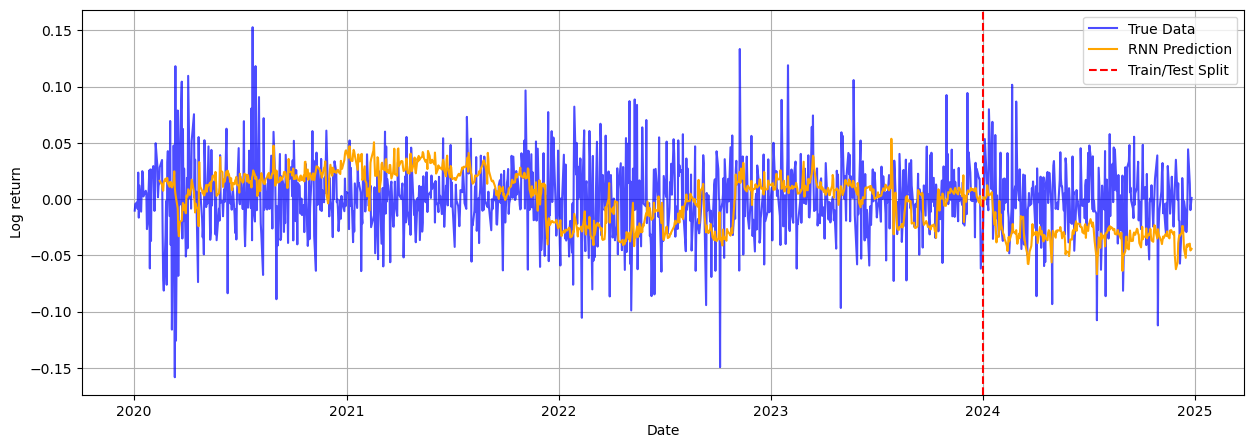

In [8]:
plt.figure(figsize=(15,5))

plt.plot(df.index, y, label="True Data", color="blue", alpha=0.7)
plt.plot(pred_index, pred_full, label="RNN Prediction", color="orange")

plt.axvline(x=pd.Timestamp("2024-01-02"),
            color="red", linestyle="--", label="Train/Test Split")

plt.xlabel("Date")
plt.ylabel("Log return")
plt.legend()
plt.grid(True)
plt.savefig("fig/log_return_vs_pred.png", dpi=300, bbox_inches="tight")
plt.show()


 Window size =  10
--------------------------------------------------


/var/folders/_q/9bb35y7928b8cwm8khhrd7900000gn/T/ipykernel_29239/2699433688.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+L])


8/8 [==============================] - 0s 45ms/step
MSE = 0.005029


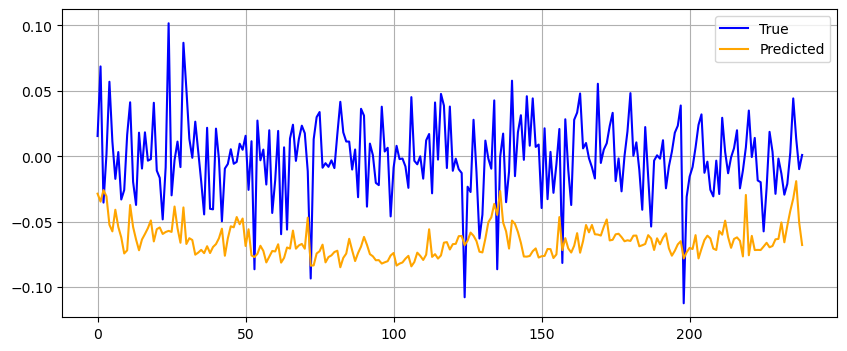


 Window size =  20
--------------------------------------------------


/var/folders/_q/9bb35y7928b8cwm8khhrd7900000gn/T/ipykernel_29239/2699433688.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+L])


8/8 [==============================] - 0s 20ms/step
MSE = 0.002197


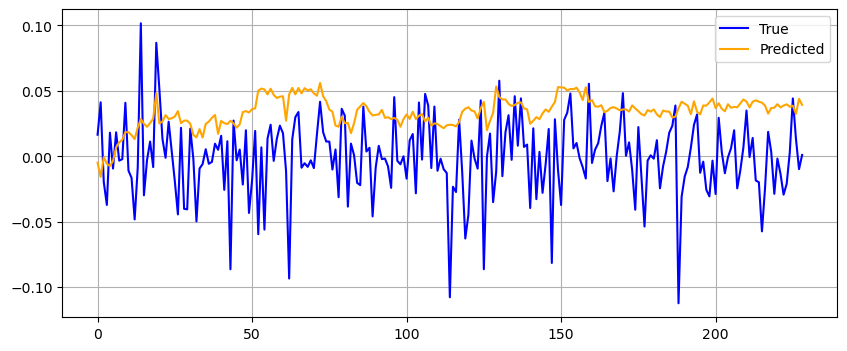


 Window size =  30
--------------------------------------------------


/var/folders/_q/9bb35y7928b8cwm8khhrd7900000gn/T/ipykernel_29239/2699433688.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+L])


7/7 [==============================] - 0s 35ms/step
MSE = 0.002686


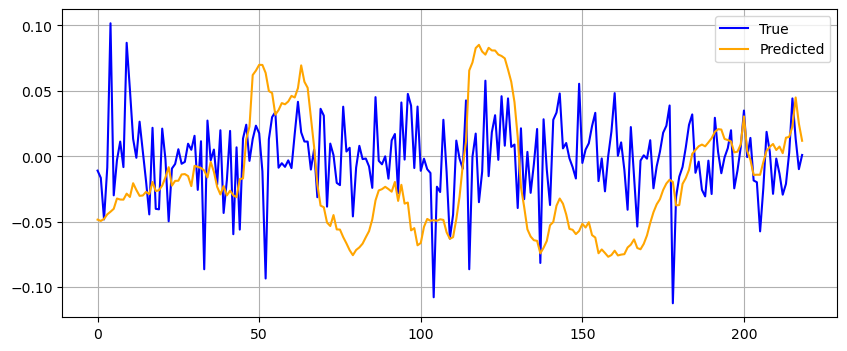


 Window size =  40
--------------------------------------------------


/var/folders/_q/9bb35y7928b8cwm8khhrd7900000gn/T/ipykernel_29239/2699433688.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+L])


7/7 [==============================] - 0s 57ms/step
MSE = 0.003800


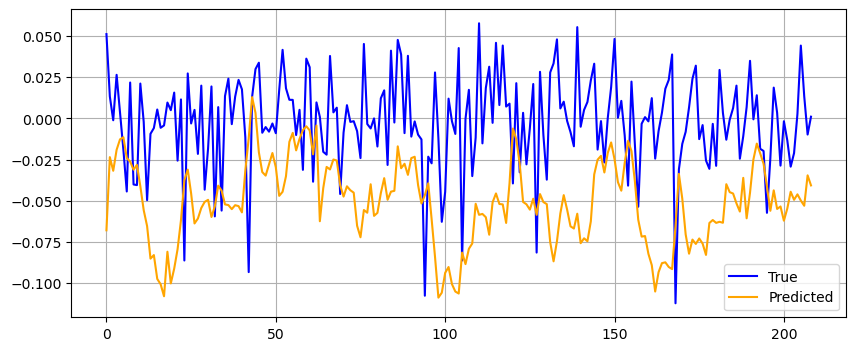

In [9]:
# Last fold: %80 train - %20 test set
tr_start, tr_end, te_start, te_end = splits[-1]

dates = df.index
train_mask = (dates >= tr_start) & (dates <= tr_end)
test_mask  = (dates >= te_start) & (dates <= te_end)

X_train_raw = df[X_cols].values[train_mask]
y_train_raw = y[train_mask]

X_test_raw  = df[X_cols].values[test_mask]
y_test_raw  = y[test_mask]


# Embedding list
embedding_list = [10, 20, 30, 40]

for L in embedding_list:

    print("\n Window size = ", L)
    print("-" * 50)

    # Create sequences
    X_train, y_train = create_sequences(X_train_raw, y_train_raw, L)
    X_test,  y_test  = create_sequences(X_test_raw,  y_test_raw,  L)

    # Reshape: (samples, timesteps=L, features)
    X_train = X_train.reshape((X_train.shape[0], L, X_train.shape[2]))
    X_test  = X_test.reshape((X_test.shape[0],  L, X_test.shape[2]))

    # RNN 
    model = Sequential([
        SimpleRNN(32, activation="tanh", input_shape=(L, X_train.shape[2])),
        Dense(16, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer=RMSprop(learning_rate=0.001), loss="mse")

    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Predict
    pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, pred)

    print(f"MSE = {mse:.6f}")

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(y_test, label="True", color="blue")
    plt.plot(pred,  label="Predicted", color="orange")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"fig/embedding_{L}.png", dpi=300, bbox_inches="tight")
    plt.show()

/var/folders/_q/9bb35y7928b8cwm8khhrd7900000gn/T/ipykernel_29239/2699433688.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+L])



Running with learning rate = 0.001
--------------------------------------------------
8/8 [==============================] - 0s 19ms/step
MSE = 0.003293


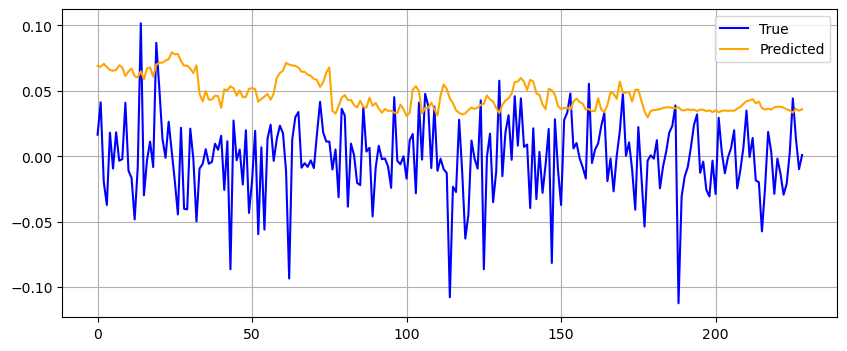


Running with learning rate = 0.005
--------------------------------------------------


/var/folders/_q/9bb35y7928b8cwm8khhrd7900000gn/T/ipykernel_29239/2699433688.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+L])


8/8 [==============================] - 0s 20ms/step
MSE = 0.004507


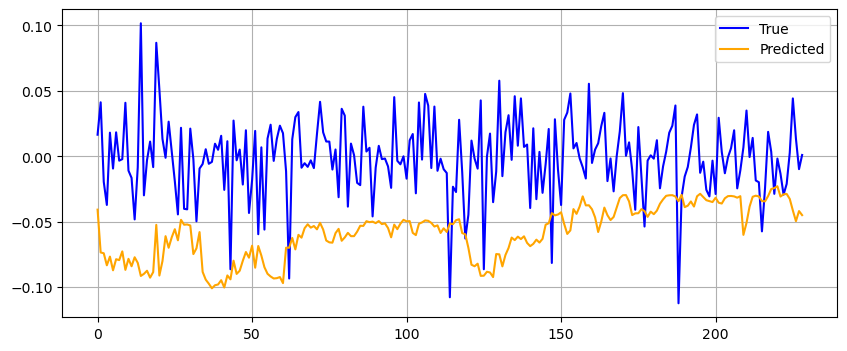

In [11]:
learning_rates = [0.001, 0.005]  
L = 20
tr_start, tr_end, te_start, te_end = splits[-1]

dates = df.index
train_mask = (dates >= tr_start) & (dates <= tr_end)
test_mask  = (dates >= te_start) & (dates <= te_end)

X_train_raw = df[X_cols].values[train_mask]
y_train_raw = y[train_mask]

X_test_raw  = df[X_cols].values[test_mask]
y_test_raw  = y[test_mask]

X_train, y_train = create_sequences(X_train_raw, y_train_raw, L)
X_test,  y_test  = create_sequences(X_test_raw,  y_test_raw,  L)

# reshape for RNN: (samples, timesteps=L, features)
X_train = X_train.reshape((X_train.shape[0], L, X_train.shape[2]))
X_test  = X_test.reshape((X_test.shape[0],  L, X_test.shape[2]))



for lr in learning_rates:

    print(f"\nRunning with learning rate = {lr}")
    print("-" * 50)

    # Prepare sequences
    X_train, y_train = create_sequences(X_train_raw, y_train_raw, L)
    X_test,  y_test  = create_sequences(X_test_raw,  y_test_raw,  L)

    # Reshape for RNN
    X_train = X_train.reshape((X_train.shape[0], L, X_train.shape[2]))
    X_test  = X_test.reshape((X_test.shape[0],  L, X_test.shape[2]))

    # RNN
    model = Sequential([
        SimpleRNN(32, activation="tanh", input_shape=(L, X_train.shape[2])),
        Dense(16, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer=RMSprop(learning_rate=lr), loss="mse")

    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Predict
    pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, pred)

    print(f"MSE = {mse:.6f}")

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(y_test, label="True", color="blue")
    plt.plot(pred,  label="Predicted", color="orange")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"fig/rnn_lr_{str(lr).replace('.', '')}_UP.png",
                dpi=300, bbox_inches="tight")
    plt.show()


Batch size = 8
--------------------------------------------------
8/8 [==============================] - 0s 19ms/step
MSE = 0.009949


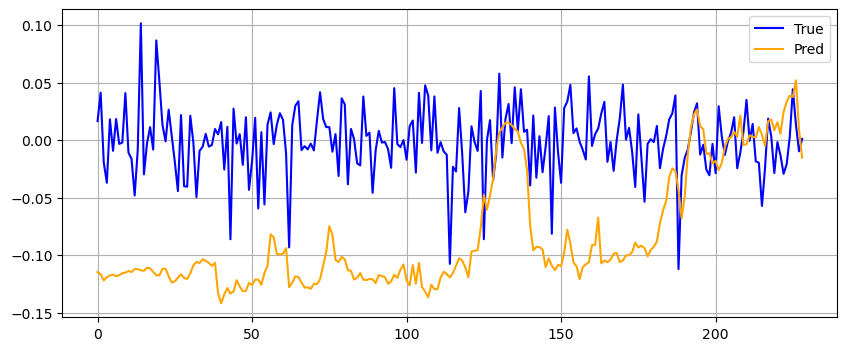


Batch size = 16
--------------------------------------------------
8/8 [==============================] - 0s 19ms/step
MSE = 0.001244


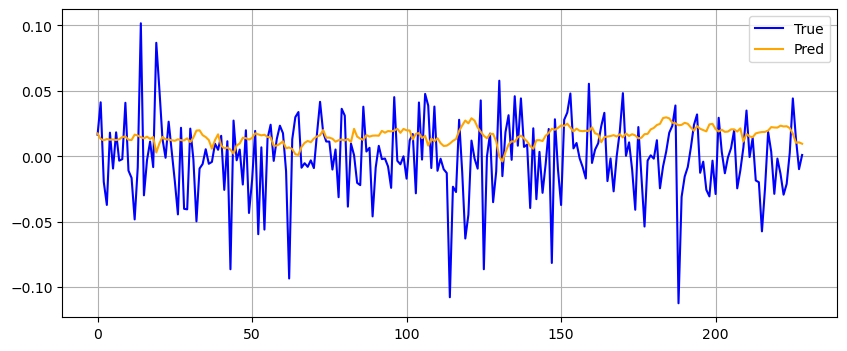


Batch size = 32
--------------------------------------------------
8/8 [==============================] - 0s 19ms/step
MSE = 0.000907


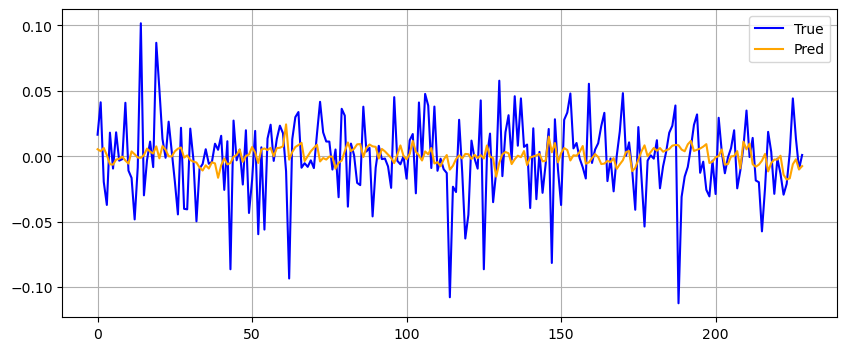


Batch size = 64
--------------------------------------------------
8/8 [==============================] - 0s 19ms/step
MSE = 0.002810


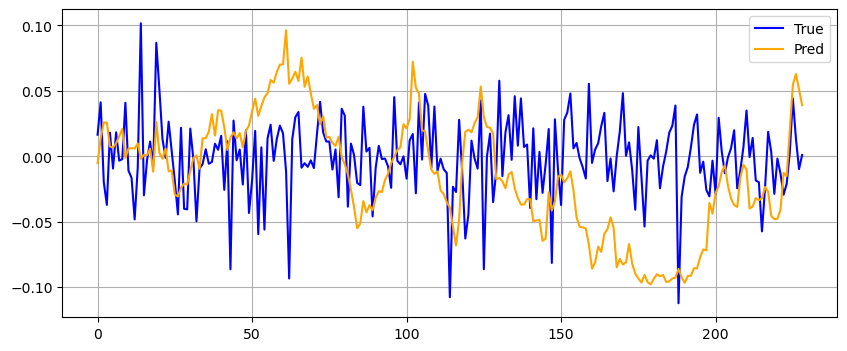

In [12]:
batch_list = [8, 16, 32, 64]
lr = 0.001   # fixed learning rate


for bat in batch_list:
    print(f"\nBatch size = {bat}")
    print("-"*50)
    # RNN
    model = Sequential([
        SimpleRNN(32, activation="tanh", input_shape=(L, X_train.shape[2])),
        Dense(16, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer=RMSprop(learning_rate=lr), loss="mse")

    model.fit(X_train, y_train, epochs=50, batch_size=bat, verbose=0)

    pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, pred)

    print(f"MSE = {mse:.6f}")

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(y_test, label="True", color="blue")
    plt.plot(pred,  label="Pred", color="orange")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"fig/rnn_batch_{bat}.png", dpi=300, bbox_inches="tight")
    plt.show()